In [4]:
import pandas as pd
import numpy as np
import traffic
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
import matplotlib.pyplot as plt
import datetime
import importlib
from matplotlib.backends.backend_pdf import PdfPages
from openap import prop
from tqdm import tqdm 
import os
import agps_config

from agps_config import AC2CONSIDER

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%load_ext autoreload
%autoreload 2
import agps_funs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
# Download and preprocessing of trajs
***

In [2]:
airport_str = 'LSZH'
trajs_filenames = ['LSZH_MAY24.pkl', 'LSZH_JUN24.pkl', 'LSZH_JUL24.pkl', 'LSZH_AUG24.pkl', 'LSZH_SEP24.pkl']
start = ["2024-05-01 00:00","2024-06-01 00:00","2024-07-01 00:00", "2024-08-01 00:00","2024-09-01 00:00"]
stop = ["2024-05-30 23:59","2024-06-30 23:59", "2024-07-31 23:59","2024-08-31 23:59","2024-09-30 23:59"]

## Downloading trajs

In [ ]:
# Download Trajs

i = 0

while i < len(start):
    timestamps = pd.date_range(start[i], stop[i], freq="4h")
    data = []
    for t1, t2 in tqdm(zip(timestamps[:-1], timestamps[1:]), total=len(timestamps) - 1, desc="Processing timestamps"):
            tmp = opensky.history(start=str(t1), stop=str(t2), bounds=airports[airport_str].shape.convex_hull.buffer(0.1))
            if tmp is not None:
                data.append(tmp.data)
            
    trajs = pd.concat(data)
    trajs = Traffic(trajs)
    trajs.to_pickle(trajs_filenames[i])
    print(trajs_filenames[i])
    i += 1

## Preprocessing, Take-off, and Pushback

In [ ]:
import agps_funs
import agps_config
from agps_funs import alternative_pushback_detection
from agps_funs import takeoff_detection
from agps_config import get_Stands_LSZH

# Number of CPUs
max_workers=8

# Load taxi-in, push-out stand areas for LSZH
stands = get_Stands_LSZH()

i = 0
while i < len(trajs_filenames):

    # Load trajs
    gnd_trajs = Traffic.from_file(trajs_filenames[i])

    # Preprocessing
    gnd_trajs = trajs.query('altitude<4000 or onground')
    gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=max_workers, desc='resampling')
    gnd_trajs = gnd_trajs.aircraft_data()
    gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=max_workers, desc='cumdist')

    # Runway classification
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, 'lszh').eval(max_workers=max_workers, desc='Takeoff Detection')

    # Pushback classification
    stands = get_Stands_LSZH()
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=max_workers, desc='Pushback Detection')


    # Save to pickle
    save_filename = trajs_filenames[i].replace('.pkl', '_gnd_trajs.pkl')
    gnd_trajs.to_pickle(save_filename)

***
# Determine Take-off Runway, Taxi-Times, etc.
***

**Known issues:**
* Noisy gnd trajs -> SWR52_1040, SWR252H_992, SAZ71_1319, SWR2HB_949, KLM38Y_350, SWR95H_1307, EDW58T_1127
* JUL: First part of taxi not classified as taxi -> ETD74_2332


**Missing Functionalities:**
* Filter take-offs with taxiway filter
* Implement Fuel Flow Estimation -> for Engine, APU & Tractor (see Figure 8 in Fleuti & Maraini 2017, p.16)


(0.0, 10.0)

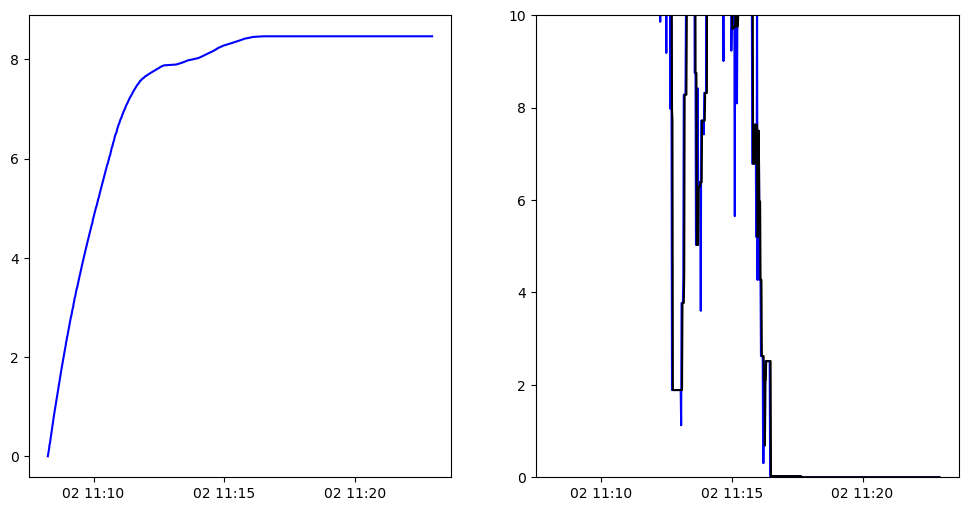

In [120]:
id = 'SFG55A_158'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(gnd_trajs[id].data.timestamp,
         gnd_trajs[id].data.cumdist, 'b')

# ax[0].plot(gnd_trajs[id].pushback('lszh').data.timestamp,
#          gnd_trajs[id].pushback('lszh').data.cumdist, 'r')

# ax[0].plot(gnd_trajs[id].on_parking_position('lszh').max().data.timestamp,
#          gnd_trajs[id].on_parking_position('lszh').max().data.cumdist, 'g')

# ax[0].plot(gnd_trajs[id].clip(standsDockE).data.timestamp,
#            gnd_trajs[id].clip(standsDockE).data.cumdist, 'm')


ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs, 'b')

ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs.rolling(5).median(), 'k')

ax[1].set_ylim(0, 10) 

#ax[1].set_xlim('2024-07-01 14:00:00', '2024-07-01 14:10:00')




***
# Fuel Estimation
***

In [19]:
importlib.reload(agps_funs)
from agps_funs import normalTaxiFuel, extAGPSTaxiFuel

gnd_trajs = gnd_trajs.iterate_lazy().pipe(normalTaxiFuel).eval(max_workers=8, desc='Taxi Fuel')
gnd_trajs = gnd_trajs.iterate_lazy().pipe(extAGPSTaxiFuel).eval(max_workers=8, desc='External AGPS')

Taxi Fuel:   0%|          | 0/1979 [00:00<?, ?it/s]

External AGPS:   0%|          | 0/1979 [00:00<?, ?it/s]

In [20]:
gnd_trajs.to_pickle(airport_str+'_gnd_JUN.pkl')

In [18]:
# Generate df_movements

# Group by 'flight_id'
grouped = gnd_trajs.query('takeoffRunway != ""').groupby('flight_id')

# Create a new DataFrame df_movements to store the summarized data
df_movements = pd.DataFrame()

# Extract the required information
df_movements['flight_id'] = grouped['flight_id'].first()
df_movements['callsign'] = grouped['callsign'].first()
df_movements['isPushback'] = grouped['isPushback'].first()
df_movements['startPushback'] = grouped['startPushback'].first()
df_movements['startTaxi'] = grouped['startTaxi'].first()
df_movements['lineupTime'] = grouped['lineupTime'].first()
df_movements['taxiDuration'] = grouped['taxiDuration'].first()
df_movements['taxiDistance'] = grouped['taxiDistance'].first()
df_movements['takeoffRunway'] = grouped['takeoffRunway'].first()
df_movements['typecode'] = grouped['typecode'].first()
df_movements['MESengine'] = grouped['MESengine'].first()
df_movements['MESapu'] = grouped['MESapu'].first()
df_movements['normTAXIengine'] = grouped['normTAXIengine'].first()
df_movements['extAGPSapu'] = grouped['extAGPSapu'].first()
df_movements['extAGPStug'] = grouped['extAGPStug'].first()


# Reset index to get a clean DataFrame
df_movements = df_movements.reset_index(drop=True)

df_movements.to_pickle('df_movements.pkl')

### Compare takeoff_from_runway() with my method

In [77]:
# Compare 
r = []

# Iterate over each flight_id in df_movements
for flight_id in df_movements['flight_id'].values:
    
    # Get the takeoff runway for the current flight_id
    tmp = gnd_trajs[flight_id].takeoff_from_runway('lszh').next()

    # If a runway is found, append it to the list, otherwise append None or a default value
    if tmp is not None:
        r.append(tmp.data.iloc[0].runway)
    else:
        r.append(None)  # or another placeholder like 'Unknown'

# Add the list `r` as a new column in df_movements
df_movements['runway'] = r


df_movements

,flight_id,callsign,taxi_start,line_up_time,taxi_duration,takeoff_runway,runway
0,AAL93_2363,AAL93,2024-07-01 12:18:08+00:00,2024-07-01 12:21:04+00:00,0 days 00:02:56,32,32
1,AAL93_2365,AAL93,2024-07-02 09:56:57+00:00,2024-07-02 09:59:28+00:00,0 days 00:02:31,32,32
2,AEA1676_049,AEA1676,2024-07-01 09:30:26+00:00,2024-07-01 09:34:43+00:00,0 days 00:04:17,32,32
3,AEA32KC_030,AEA32KC,2024-07-01 17:14:23+00:00,2024-07-01 17:21:31+00:00,0 days 00:07:08,32,32
4,AEA32KC_036,AEA32KC,2024-07-02 16:55:06+00:00,2024-07-02 17:02:42+00:00,0 days 00:07:36,32,32
...,...,...,...,...,...,...,...
690,VLG5YD_032,VLG5YD,2024-07-02 07:46:51+00:00,2024-07-02 07:54:14+00:00,0 days 00:07:23,28,10
691,VLG5YD_045,VLG5YD,2024-07-01 10:11:19+00:00,2024-07-01 10:18:35+00:00,0 days 00:07:16,32,32
692,VLG6473_035,VLG6473,2024-07-02 13:08:22+00:00,2024-07-02 13:13:15+00:00,0 days 00:04:53,32,14
693,XAFTY_016,XAFTY,2024-07-02 13:11:14+00:00,2024-07-02 13:17:43+00:00,0 days 00:06:29,32,32


In [95]:
df_movements['is_identical'] = df_movements['TO_runway'] == df_movements['runway']
num_differences = df_movements['is_identical'].value_counts()[False]

# Percentace of differences between takeoff_from_runway() and my method:
print(num_differences/len(df_movements))

# Which runways are not identified properly?
differences = df_movements[df_movements['TO_runway'] != df_movements['runway']]
mismatched_values = differences[['flight_id', 'takeoff_runway', 'runway']]

# Group by TO_runway and runway, then count the occurrences
df_movements.groupby(['takeoff_runway', 'runway']).size().reset_index(name='count')

0.2839160839160839


,TO_runway,runway,count
0,16,16,16
1,28,10,25
2,28,28,128
3,32,10,2
4,32,14,142
5,32,16,18
6,32,28,2
7,32,32,356
8,34,16,2
9,34,34,12


### Load df_movements from pickle (only if required)

In [4]:
df_movements = pd.read_pickle('df_movements_JUL24.pkl')
df_movements

,flight_id,callsign,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,takeoffRunway,typecode,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPStug
0,9AJET_33308,9AJET,False,NaT,2024-07-09 17:29:52+00:00,2024-07-09 17:31:41+00:00,0 days 00:01:49,0.055162,28,C25A,NaN,NaN,NaN,NaN,NaN
1,9AJET_33310,9AJET,False,NaT,2024-07-13 08:13:39+00:00,2024-07-13 08:16:56+00:00,0 days 00:03:17,0.142376,28,C25A,NaN,NaN,NaN,NaN,NaN
2,9AJET_33312,9AJET,False,NaT,2024-07-16 12:46:25+00:00,2024-07-16 12:52:36+00:00,0 days 00:06:11,0.758783,32,C25A,NaN,NaN,NaN,NaN,NaN
3,9AJIP_33529,9AJIP,False,NaT,2024-07-25 14:02:05+00:00,2024-07-25 14:11:26+00:00,0 days 00:09:21,0.169736,28,C25A,NaN,NaN,NaN,NaN,NaN
4,9HGRM_32850,9HGRM,False,NaT,2024-07-29 14:21:40+00:00,2024-07-29 14:27:39+00:00,0 days 00:05:59,0.206244,28,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11925,XRO1251_2332,XRO1251,False,NaT,2024-07-25 12:54:32+00:00,2024-07-25 12:57:06+00:00,0 days 00:02:34,0.236827,28,H25B,NaN,NaN,NaN,NaN,NaN
11926,XRO1264_2638,XRO1264,False,NaT,2024-07-17 13:34:25+00:00,2024-07-17 13:38:12+00:00,0 days 00:03:47,0.185188,28,PRM1,NaN,NaN,NaN,NaN,NaN
11927,XRO1265_2640,XRO1265,False,NaT,2024-07-24 09:15:22+00:00,2024-07-24 09:16:35+00:00,0 days 00:01:13,0.135259,28,PRM1,NaN,NaN,NaN,NaN,NaN
11928,XRO1265_2642,XRO1265,False,NaT,2024-07-25 06:13:23+00:00,2024-07-25 06:20:05+00:00,0 days 00:06:42,0.197455,28,PRM1,NaN,NaN,NaN,NaN,NaN


***
# Some stats
***

### Daten aus dem Lärmbulletin der FZAG

| Datum     | RWY 10 | RWY 16 | RWY 28 | RWY 32 | RWY 34 | TOTAL  |
|-----------|-------:|-------:|-------:|-------:|-------:|-------:|
| 01.06.24  | 0      | 36     | 235    | 84     | 3      | 358    |
| 02.06.24  | 0      | 35     | 225    | 131    | 6      | 397    |
| Jun01+02  | 0      | 71     | 460    | 215    | 9      | 755    |
| JUN24     | 0      | 1151   | 7309   | 2826   | 155    | 11441  |
| JUL24     | 29     | 1497   | 6841   | 3594   | 144    | 12105  |

In [8]:
# Group by TO_runway and calculate mean and std
overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count', 'mean', 'std']).reset_index()

overview['FZAG_count_JUL24'] = [29, 0, 1497, 6841, 3594, 144]

overview['error_abs'] = overview['count'] - overview['FZAG_count_JUL24']
overview['error_rel'] = (overview['error_abs'] / overview['count']) * 100

# Display the result
overview

,takeoffRunway,count,mean,std,FZAG_count_JUL24,error_abs,error_rel
0,10,28,0 days 00:10:54.571428571,0 days 00:03:08.234374900,29,-1,-3.571429
1,14,2,0 days 00:03:39,0 days 00:03:46.274169979,0,2,100.000000
2,16,1450,0 days 00:13:18.480689655,0 days 00:05:07.075240878,1497,-47,-3.241379
3,28,6788,0 days 00:07:39.551856216,0 days 00:04:32.764799299,6841,-53,-0.780790
4,32,3520,0 days 00:08:06.794318181,0 days 00:04:08.516944134,3594,-74,-2.102273
5,34,142,0 days 00:10:35.133802816,0 days 00:04:20.931887769,144,-2,-1.408451


***
# Some illustrations
***

### Check runway classification

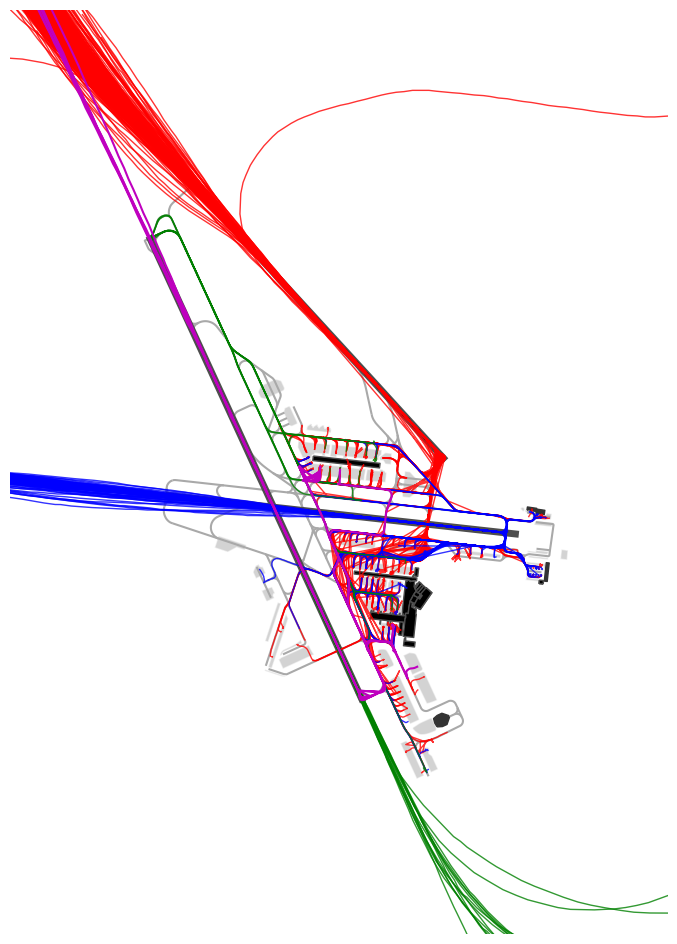

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

# gnd_trajs['XAFTY_016'].plot(ax=ax, color='r')

gnd_trajs[df_movements.query('takeoff_runway == "32"').flight_id.values].plot(ax=ax, color='r')
gnd_trajs[df_movements.query('takeoff_runway == "28"').flight_id.values].plot(ax=ax, color='b')
gnd_trajs[df_movements.query('takeoff_runway == "16"').flight_id.values].plot(ax=ax, color='g')
gnd_trajs[df_movements.query('takeoff_runway == "34"').flight_id.values].plot(ax=ax, color='m')
# gnd_trajs[df_movements.query('TO_runway == "10"').flight_id.values].plot(ax=ax, color='y')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

### Plot taxi-part of trajs to pdf

In [19]:
importlib.reload(agps_funs)
from agps_funs import plotTrajs2PDF
from agps_config import AC2CONSIDER

# Define which flights should be considered for plotting
flt_ids = df_movements.flight_id

# Filter df_movements accordingly
df_filtered = df_movements[df_movements['flight_id'].isin(flt_ids)]
df_filtered = df_filtered[df_filtered['typecode'].isin(AC2CONSIDER)]
df_filtered

# Pick trajectories randomly and plot to pdf
plotTrajs2PDF(df_filtered,
              gnd_trajs,
              nPages = 3,
              trajsPerPage = 5,
              airport_str = 'LSZH',
              rwys = rwys)

***
# Fuel Consumption Estimation
***


The process definition (main engine start, taxi, pushback, etc.) is based on information provided in Fleuti and Marinani (2017):
https://www.flughafen-zuerich.ch/-/jssmedia/airport/portal/dokumente/das-unternehmen/politics-and-responsibility/environmental-protection/technische-berichte/2017_taxi_study_zurichairport.pdf?vs=1


## Engine Fuel Consumption

Fleuti: According to the ICAO certification LTO definition, the phase of taxi or idle is assumed to be at a uniform 7% thrust of the engine. The fuel flow – and the resulting emissions – have been measured and certified at this thrust level. --> This corresponds to the "idle thrust" setting reported in the ICAO Engine Emissions Databank.

ICAO Engine Emissions Databank


## APU Fuel Consumption
ICAO Document 9889
ICAO Document 9889 7.2 Unlike aircraft main engines, APUs are not certificated for emissions, and the manufacturers generally
consider information on APU emissions rates as proprietary. As a result, little data are publicly available to serve as a
basis for calculating APU emissions.

ICAO Document 9889 Table 3-A1-5:
| Mode           | Two Engine A/C                  | Four Engine A/C               |
|----------------|---------------------------------|-------------------------------|
| Start-up       | 3 minutes                       | 3 minutes                     | 
| Normal Running | Pre-dep. running time: 3.6min   | Pre-dep. running time: 5.3min |
| High-load      | Engine start: 35 seconds        | Engine start: 140 seconds     |


## AGPS Fuel

(without considering operational constraints, e.g. where to disconnect AGPS)

**Variables**:
* Warmup time (Default: Engine warm up if shut down for less than two hours is 2 minutes at idle, if shutdown for more than two hours warmup is 5 minutes at idle, according to https://www.pprune.org/archive/index.php/t-624084.html)
* Minimum AGPS-Time

In [67]:
df_movements = pd.read_pickle('df_movements_JUL24.pkl')
#df_movements = pd.read_pickle('df_movements.pkl')
df_movements

,flight_id,callsign,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,takeoffRunway,typecode,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPStug
0,9AJET_33308,9AJET,False,NaT,2024-07-09 17:29:52+00:00,2024-07-09 17:31:41+00:00,0 days 00:01:49,0.055162,28,C25A,NaN,NaN,NaN,NaN,NaN
1,9AJET_33310,9AJET,False,NaT,2024-07-13 08:13:39+00:00,2024-07-13 08:16:56+00:00,0 days 00:03:17,0.142376,28,C25A,NaN,NaN,NaN,NaN,NaN
2,9AJET_33312,9AJET,False,NaT,2024-07-16 12:46:25+00:00,2024-07-16 12:52:36+00:00,0 days 00:06:11,0.758783,32,C25A,NaN,NaN,NaN,NaN,NaN
3,9AJIP_33529,9AJIP,False,NaT,2024-07-25 14:02:05+00:00,2024-07-25 14:11:26+00:00,0 days 00:09:21,0.169736,28,C25A,NaN,NaN,NaN,NaN,NaN
4,9HGRM_32850,9HGRM,False,NaT,2024-07-29 14:21:40+00:00,2024-07-29 14:27:39+00:00,0 days 00:05:59,0.206244,28,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11925,XRO1251_2332,XRO1251,False,NaT,2024-07-25 12:54:32+00:00,2024-07-25 12:57:06+00:00,0 days 00:02:34,0.236827,28,H25B,NaN,NaN,NaN,NaN,NaN
11926,XRO1264_2638,XRO1264,False,NaT,2024-07-17 13:34:25+00:00,2024-07-17 13:38:12+00:00,0 days 00:03:47,0.185188,28,PRM1,NaN,NaN,NaN,NaN,NaN
11927,XRO1265_2640,XRO1265,False,NaT,2024-07-24 09:15:22+00:00,2024-07-24 09:16:35+00:00,0 days 00:01:13,0.135259,28,PRM1,NaN,NaN,NaN,NaN,NaN
11928,XRO1265_2642,XRO1265,False,NaT,2024-07-25 06:13:23+00:00,2024-07-25 06:20:05+00:00,0 days 00:06:42,0.197455,28,PRM1,NaN,NaN,NaN,NaN,NaN


In [68]:
from agps_config import AC2CONSIDER

df_movements = df_movements[df_movements['typecode'].isin(AC2CONSIDER)]
df_movements

,flight_id,callsign,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,takeoffRunway,typecode,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPStug
5,A7HHJ_167,A7HHJ,False,NaT,2024-07-25 12:30:06+00:00,2024-07-25 12:44:13+00:00,0 days 00:14:07,1.391277,28,A319,42.84,8.000000,172.788,25.880556,NaN
8,AAL93_36573,AAL93,True,2024-07-01 12:12:38+00:00,2024-07-01 12:14:31+00:00,2024-07-01 12:21:09+00:00,0 days 00:06:38,0.521919,32,B788,93.66,16.666667,177.508,26.312222,NaN
9,AAL93_36577,AAL93,True,2024-07-22 10:00:22+00:00,2024-07-22 10:01:40+00:00,2024-07-22 10:13:13+00:00,0 days 00:11:33,0.463228,32,B788,93.66,16.666667,309.078,45.815000,NaN
10,AAL93_36578,AAL93,True,2024-07-24 09:49:12+00:00,2024-07-24 09:51:11+00:00,2024-07-24 10:05:40+00:00,0 days 00:14:29,1.470297,16,B788,93.66,16.666667,387.574,57.450556,NaN
11,AAL93_36580,AAL93,True,2024-07-25 09:56:21+00:00,2024-07-25 09:57:52+00:00,2024-07-25 10:07:37+00:00,0 days 00:09:45,1.539849,16,B788,93.66,16.666667,260.910,38.675000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11893,VLG7516_825,VLG7516,True,2024-07-10 12:41:33+00:00,2024-07-10 12:42:10+00:00,2024-07-10 12:50:21+00:00,0 days 00:08:11,0.474218,28,A20N,33.60,8.000000,78.560,15.002778,NaN
11894,VLG7516_826,VLG7516,False,NaT,2024-07-12 13:29:15+00:00,2024-07-12 13:34:32+00:00,0 days 00:05:17,0.372545,32,A20N,33.60,8.000000,50.720,9.686111,NaN
11895,VLG7516_834,VLG7516,False,NaT,2024-07-17 13:13:44+00:00,2024-07-17 13:27:42+00:00,0 days 00:13:58,0.569193,28,A20N,33.60,8.000000,134.080,25.605556,NaN
11896,VLG7516_840,VLG7516,True,2024-07-24 12:40:44+00:00,2024-07-24 12:41:40+00:00,2024-07-24 12:51:50+00:00,0 days 00:10:10,0.577541,28,A20N,33.60,8.000000,97.600,18.638889,NaN


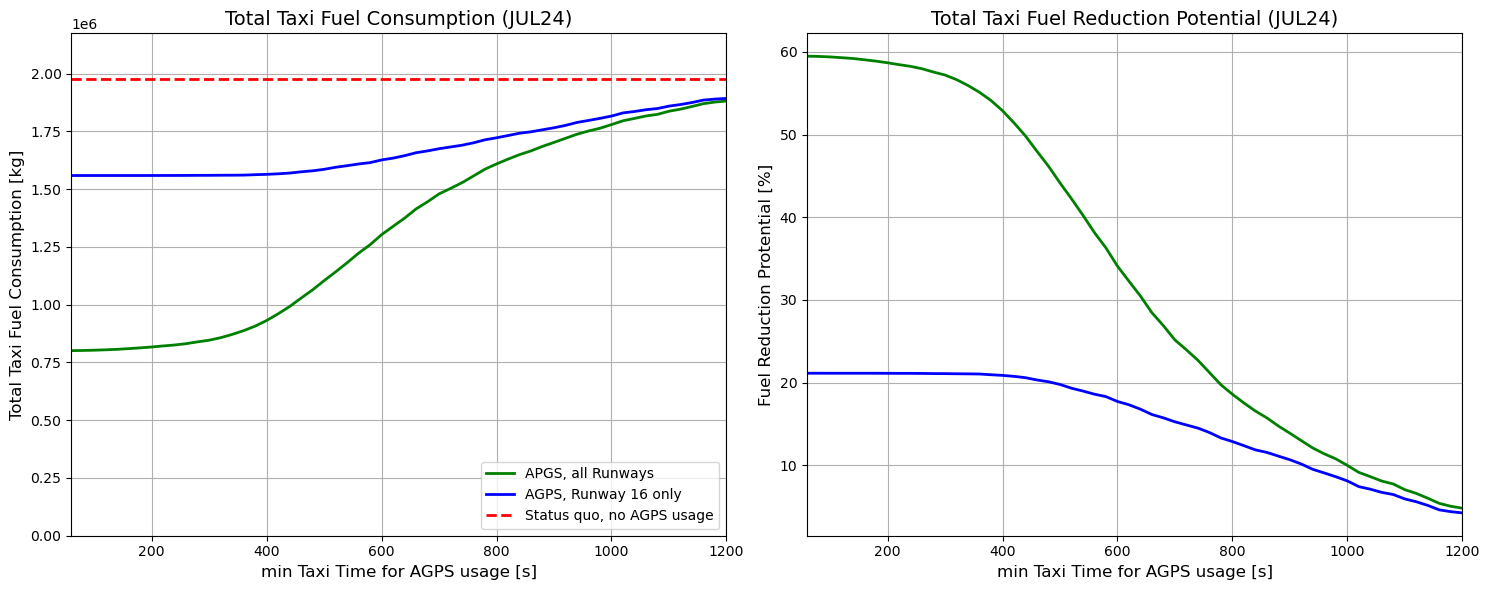

In [86]:
baseline = df_movements['MESengine'].sum() + df_movements['MESapu'].sum() + df_movements['normTAXIengine'].sum()


minTaxiDuration = np.arange(60,1201,20)

AGPS_rwy_all = []
AGPS_rwy_16 = []


for taxiDuration in minTaxiDuration:

    MES_eng_apu = df_movements['MESengine'].sum() + df_movements['MESapu'].sum()

    agps_fuel = df_movements[df_movements['taxiDuration']>=datetime.timedelta(seconds=int(taxiDuration))][['extAGPSapu', 'extAGPStug']].sum().sum()
    non_agps_fuel = df_movements[df_movements['taxiDuration']<datetime.timedelta(seconds=int(taxiDuration))]['normTAXIengine'].sum()
    AGPS_rwy_all.append(MES_eng_apu + agps_fuel+ non_agps_fuel)

    agps_fuel = df_movements.query('takeoffRunway == "16"')[df_movements['taxiDuration']>=datetime.timedelta(seconds=int(taxiDuration))][['extAGPSapu', 'extAGPStug']].sum().sum()
    non_agps_fuel = df_movements.query('takeoffRunway == "16"')[df_movements['taxiDuration']<datetime.timedelta(seconds=int(taxiDuration))]['normTAXIengine'].sum() + df_movements.query('takeoffRunway != "16"')['normTAXIengine'].sum()
    AGPS_rwy_16.append(MES_eng_apu + agps_fuel + non_agps_fuel)
    

# Plot the results to see how minAGPSDuration affects total fuel consumption
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(minTaxiDuration, 
            AGPS_rwy_all, 
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)

axs[0].plot(minTaxiDuration,
            AGPS_rwy_16,
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

# Add a horizontal line at a specific y-value (e.g., y=1000)
axs[0].axhline(y=baseline, color='r', linestyle='--', linewidth=2, label='Status quo, no AGPS usage')

axs[0].set_xlim((min(minTaxiDuration), max(minTaxiDuration)))
axs[0].set_ylim((0, baseline * 1.1))

# Customize the plot
axs[0].set_title('Total Taxi Fuel Consumption (JUL24)', fontsize=14)
axs[0].set_xlabel('min Taxi Time for AGPS usage [s]', fontsize=12)
axs[0].set_ylabel('Total Taxi Fuel Consumption [kg]', fontsize=12)
axs[0].grid(True)
axs[0].legend(loc='lower right')


axs[1].plot(minTaxiDuration,
            (baseline - AGPS_rwy_all)/baseline * 100,
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)


axs[1].plot(minTaxiDuration,
            (baseline - AGPS_rwy_16)/baseline * 100,
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

axs[1].set_xlim((min(minTaxiDuration), max(minTaxiDuration)))
axs[1].set_title('Total Taxi Fuel Reduction Potential (JUL24)', fontsize=14)
axs[1].set_xlabel('min Taxi Time for AGPS usage [s]', fontsize=12)
axs[1].set_ylabel('Fuel Reduction Protential [%]', fontsize=12)
axs[1].grid(True)



plt.tight_layout()
# Save the figure as a PDF
plt.savefig('taxi_fuel_JUL24.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


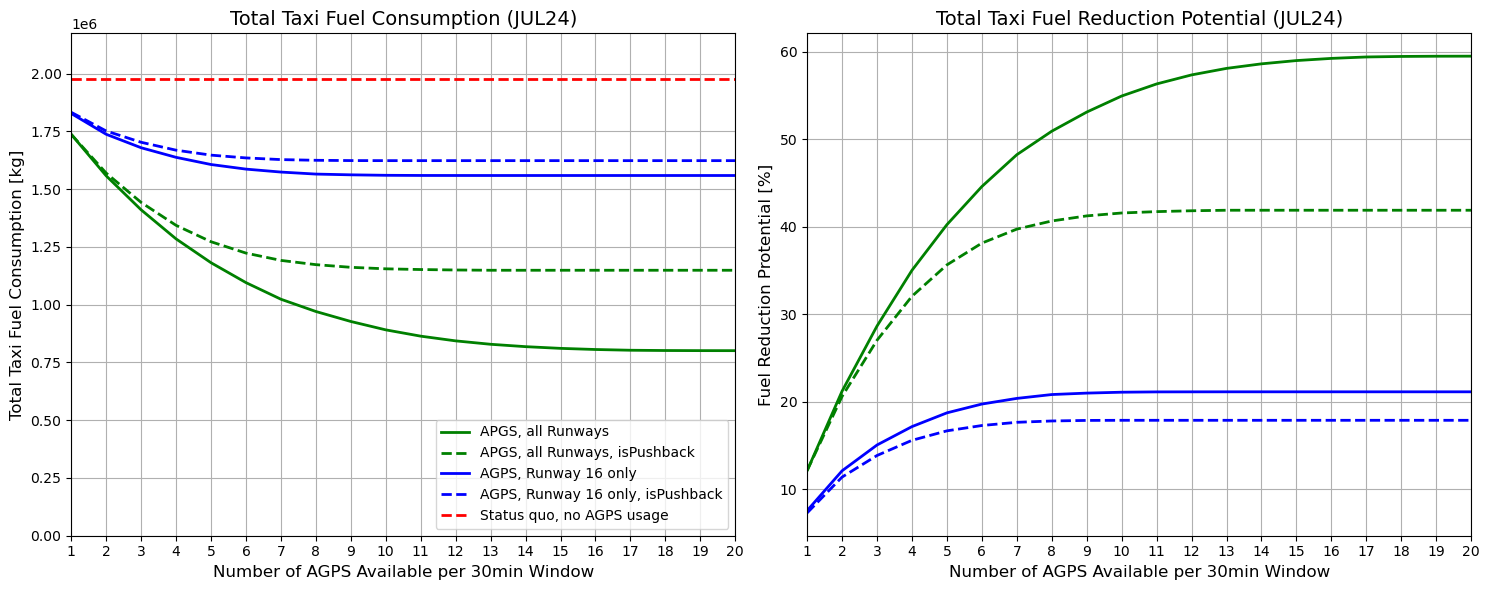

In [141]:
# Create a new column for half-hour intervals
df_movements = df_movements[df_movements['typecode'].isin(AC2CONSIDER)]
df_movements.loc[:, 'startTaxi_half_hour'] = df_movements['startTaxi'].dt.floor('30T')

# Sort by taxiDuration within each group
df_sorted = df_movements.sort_values(['startTaxi_half_hour', 'taxiDuration'], ascending=[True, False])


nTugs = np.arange(1,21,1)

AGPS_rwy_all = []
AGPS_rwy_16 = []
AGPS_rwy_all_pb = []
AGPS_rwy_16_pb = []


MES_eng_apu = df_movements['MESengine'].sum() + df_movements['MESapu'].sum()


def calculate_fuel(df, nTug, filter_condition=None):
    """
    Calculate the total fuel used based on tugs assigned to aircraft.

    Parameters:
    - df: DataFrame containing the flight data.
    - nTug: The number of tugs available.
    - filter_condition: A query string to filter the DataFrame, e.g., 'takeoffRunway == "16"'. If None, no filtering is applied.

    Returns:
    - Total fuel used (agps_fuel + non_agps_fuel).
    """
    
    if filter_condition:
        # Filter the DataFrame based on the condition provided
        df_filtered = df.query(filter_condition)
    else:
        # No filtering, use the entire DataFrame
        df_filtered = df
    
    # Assign tugs to the top 'nTug' movements based on the startTaxi_half_hour
    df_tugs = df_filtered.groupby('startTaxi_half_hour').head(nTug)
    
    # Calculate the fuel used by movements with tugs
    agps_fuel = df_tugs[['extAGPSapu', 'extAGPStug']].sum().sum()
    
    # Find the remaining movements that do not have tugs
    df_remaining = df[~df.index.isin(df_tugs.index)]
    
    # Calculate the fuel used by movements without tugs
    non_agps_fuel = df_remaining['normTAXIengine'].sum()
    
    # Total fuel used
    total_fuel = agps_fuel + non_agps_fuel
    
    return total_fuel


for nTug in nTugs:
    # Group by half-hour intervals and select the top nTug rows in each group -> These movements are assigned a tug.
    AGPS_rwy_all.append(MES_eng_apu + calculate_fuel(df_sorted, nTug))
    AGPS_rwy_all_pb.append(MES_eng_apu + calculate_fuel(df_sorted, nTug, filter_condition='isPushback'))


    # Same procedure, but only aircraft taking-off on runway 16 are assinged a tug
    AGPS_rwy_16.append(MES_eng_apu + calculate_fuel(df_sorted, nTug, filter_condition='takeoffRunway == "16"'))
    AGPS_rwy_16_pb.append(MES_eng_apu + calculate_fuel(df_sorted, nTug, filter_condition='(takeoffRunway == "16") & isPushback'))

# Plot the results to see how minAGPSDuration affects total fuel consumption
from matplotlib.ticker import MultipleLocator
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(nTugs, 
            AGPS_rwy_all, 
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)

axs[0].plot(nTugs, 
            AGPS_rwy_all_pb, 
            color = 'g',
            label='APGS, all Runways, isPushback',
            linewidth = 2,
            linestyle='--')

axs[0].plot(nTugs,
            AGPS_rwy_16,
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

axs[0].plot(nTugs,
            AGPS_rwy_16_pb,
            color= 'b',
            label='AGPS, Runway 16 only, isPushback',
            linewidth = 2,
            linestyle='--')

# Add a horizontal line at a specific y-value (e.g., y=1000)
axs[0].axhline(y=baseline, color='r', linestyle='--', linewidth=2, label='Status quo, no AGPS usage')

axs[0].set_xlim((min(nTugs), max(nTugs)))
axs[0].xaxis.set_major_locator(MultipleLocator(1))
axs[0].set_ylim((0, baseline * 1.1))

# Customize the plot
axs[0].set_title('Total Taxi Fuel Consumption (JUL24)', fontsize=14)
axs[0].set_xlabel('Number of AGPS Available per 30min Window', fontsize=12)
axs[0].set_ylabel('Total Taxi Fuel Consumption [kg]', fontsize=12)
axs[0].grid(True)
axs[0].legend(loc='lower right')


axs[1].plot(nTugs,
            (baseline - AGPS_rwy_all)/baseline * 100,
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)

axs[1].plot(nTugs,
            (baseline - AGPS_rwy_all_pb)/baseline * 100,
            color = 'g',
            label='APGS, all Runways, isPushback',
            linewidth = 2,
            linestyle='--')


axs[1].plot(nTugs,
            (baseline - AGPS_rwy_16)/baseline * 100,
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

axs[1].plot(nTugs,
            (baseline - AGPS_rwy_16_pb)/baseline * 100,
            color = 'b',
            label='APGS, Runway 16 only, isPushback',
            linewidth = 2,
            linestyle='--')

axs[1].set_xlim((min(nTugs), max(nTugs)))
axs[1].xaxis.set_major_locator(MultipleLocator(1))
axs[1].set_title('Total Taxi Fuel Reduction Potential (JUL24)', fontsize=14)
axs[1].set_xlabel('Number of AGPS Available per 30min Window', fontsize=12)
axs[1].set_ylabel('Fuel Reduction Protential [%]', fontsize=12)
axs[1].grid(True)


plt.tight_layout()
# Save the figure as a PDF
plt.savefig('taxi_fuel_ntugs_JUL24.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


/var/folders/84/0lntlwrj46zgpwppnsr6znzw0000gr/T/ipykernel_21114/1488927588.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movements['taxiDuration_seconds'] = df_movements['taxiDuration'].dt.total_seconds()


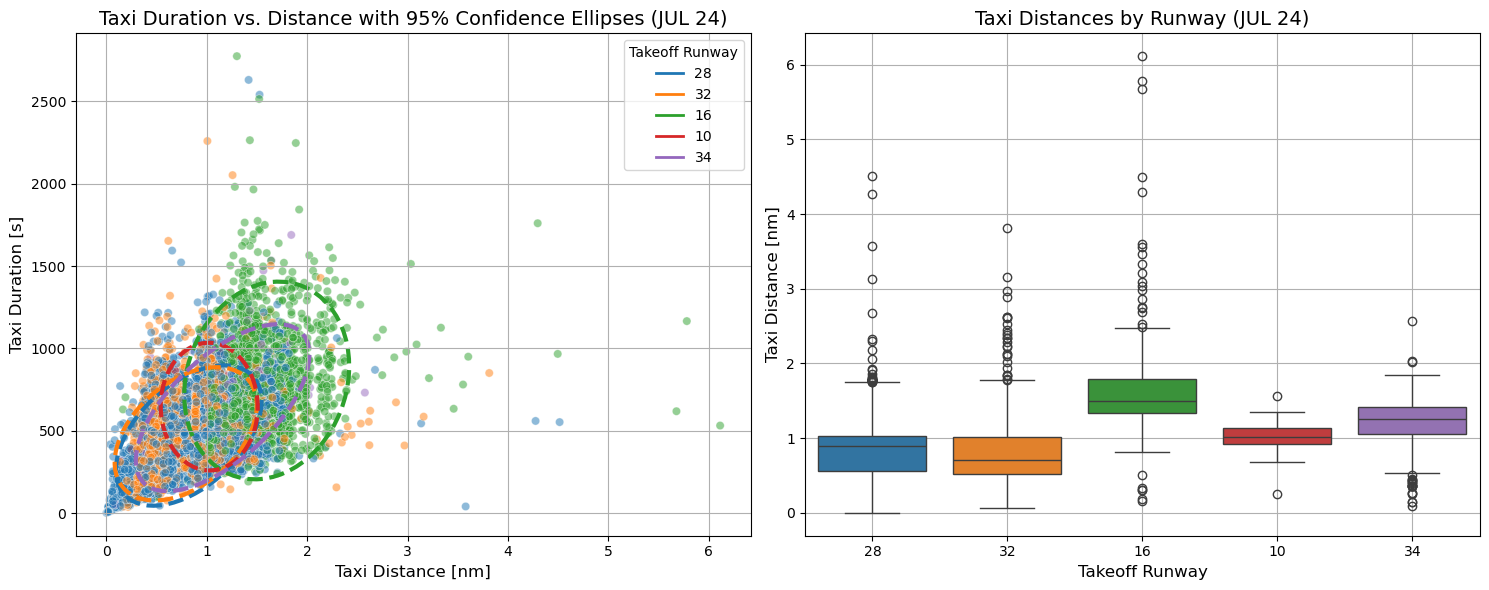

In [50]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
import seaborn as sns

# Convert taxiDuration to total seconds for scatter plotting
df_movements['taxiDuration_seconds'] = df_movements['taxiDuration'].dt.total_seconds()

# Filter out rows where takeoffRunway is "10"
#df_filtered = df_movements[df_movements['takeoffRunway'] != '10']
df_filtered = df_movements[df_movements['takeoffRunway'] != '14']

# Get rid of the worst outliers
df_filtered = df_filtered.query('taxiDistance < 7.5').query('taxiDuration_seconds < 3000')

# Set a nicer color palette
sns.set_palette("tab10")

# Function to draw an ellipse representing the 95% confidence interval
def confidence_ellipse(x, y, ax, n_std=1.96, edgecolor='black', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radii.

    edgecolor : str
        The color of the ellipse's edge.

    kwargs : dict
        Additional keyword arguments to `matplotlib.patches.Ellipse`.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, edgecolor=edgecolor, facecolor='none', linewidth=3, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    transf = (
        transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean_x, mean_y)
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Scatter plot of Taxi Duration vs. Taxi Distance colored by takeoffRunway
scatter = sns.scatterplot(
    data=df_filtered,
    x='taxiDistance', 
    y='taxiDuration_seconds', 
    hue='takeoffRunway', 
    palette='tab10',  # Use a nicer color palette
    ax=axs[0],
    alpha=0.5,  # Set scatter points with slight alpha
    legend=False
)

# Add 95% confidence ellipses for each runway
palette = sns.color_palette("tab10")  # Get the current color palette
runway_colors = {runway: palette[i] for i, runway in enumerate(df_filtered['takeoffRunway'].unique())}

for runway in df_filtered['takeoffRunway'].unique():
    subset = df_filtered[df_filtered['takeoffRunway'] == runway]
    confidence_ellipse(
        subset['taxiDistance'], 
        subset['taxiDuration_seconds'],
        axs[0], 
        edgecolor=runway_colors[runway],
        linestyle='--',
        alpha=1,
    )

axs[0].set_xlabel('Taxi Distance [nm]', fontsize = 12)
axs[0].set_ylabel('Taxi Duration [s]', fontsize = 12)
axs[0].set_title('Taxi Duration vs. Distance with 95% Confidence Ellipses (JUL 24)', fontsize=14)
axs[0].grid(True)

# Create custom legend handles for the ellipses
custom_lines = [Line2D([0], [0], color=runway_colors[runway], lw=2) for runway in df_filtered['takeoffRunway'].unique()]
axs[0].legend(custom_lines, df_filtered['takeoffRunway'].unique(), title='Takeoff Runway')


# Right subplot: Box plot of Taxi Distances for each runway
sns.boxplot(
    data=df_filtered,
    x='takeoffRunway',
    y='taxiDistance',
    palette='tab10',  # Use the same color palette
    ax=axs[1]
)
axs[1].set_xlabel('Takeoff Runway', fontsize = 12)
axs[1].set_ylabel('Taxi Distance [nm]', fontsize = 12)
axs[1].set_title('Taxi Distances by Runway (JUL 24)', fontsize=14)
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('taxi_distance_duration_JUL24.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()